<h1>Consolidated Cleaning steps</h1>

In [44]:
import os
import re

import pandas as pd

from datetime import datetime as dt

import matplotlib.pyplot as plt
%matplotlib inline


data_dir = '/Users/boyuliu/pyprojects/Joann/Joann-Thailand-Project/notebooks/datasets/new_dataset/'
# cases_kpis = data_dir + 'cases_kpis.csv'
demand2017 = data_dir + 'demand_data.csv'
demand2018 = '/Users/boyuliu/Dropbox (MIT)/Boyu-Joann/Data/Demand_data/clean/demand_2018_complete.csv'
demand2019 = '/Users/boyuliu/Dropbox (MIT)/Boyu-Joann/Data/Demand_data/clean/demand_2019_complete.csv'
demand2020 = data_dir + '2020_demand_data.csv'

data2017 = pd.read_csv(demand2017)
print(data2017.shape)
data2018 = pd.read_csv(demand2018)
print(data2018.shape)
data2019 = pd.read_csv(demand2019)
print(data2019.shape)
data2020 = pd.read_csv(demand2020)
print(data2020.shape)

(3093, 22)
(5533, 12)
(7053, 12)
(991, 12)


In [45]:
data2019.loc[data2019['Week']=='Jan-19','Week']  = '01-2019'
data2019.loc[data2019['Week']=='Feb-19','Week']  = '02-2019'
data2019.loc[data2019['Week']=='Mar-19','Week']  = '03-2019'
data2019.loc[data2019['Week']=='Apr-19','Week']  = '04-2019'
data2019.loc[data2019['Week']=='May-19','Week']  = '05-2019'
data2019.loc[data2019['Week']=='Jun-19','Week']  = '06-2019'
data2019.loc[data2019['Week']=='Jul-19','Week']  = '07-2019'
data2019.loc[data2019['Week']=='Aug-19','Week']  = '08-2019'
data2019.loc[data2019['Week']=='Sep-19','Week']  = '09-2019'
data2019.loc[data2019['Week']=='Oct-19','Week']  = '10-2019'
data2019.loc[data2019['Week']=='Nov-19','Week']  = '11-2019'
data2019.loc[data2019['Week']=='Dec-19','Week']  = '12-2019'
data2017.loc[data2017['industry']=='Natural Resources', 'industry'] = 'Mining'
data2017.loc[data2017['industry']=='Recycling', 'industry'] = 'Waste Management and Recycling'
data2017.loc[data2017['industry']=='Agriculture and Livestock', 'industry'] = 'Agriculture and Forestry'

In [46]:
# parse weeks
## file contains data from 2018 but they are legit
data2017['week_num'] = data2017['week'].apply(lambda x: int(x.split('-')[0]))
data2017['year'] = data2017['week'].apply(lambda x: int(x.split('-')[1]))

data2018.loc[data2018['week']=='31-2019', 'week'] = '31-2018' # data entry error
data2018['week_num'] = data2018['week'].apply(lambda x: int(x.split('-')[0]))
data2018['year'] = data2018['week'].apply(lambda x: int(x.split('-')[1]))

data2019.loc[data2019['Week']=='25-2016', 'Week'] = '25-2019' # data entry error
data2019['week_num'] = data2019['Week'].apply(lambda x: int(x.split('-')[0]))
data2019['year'] = data2019['Week'].apply(lambda x: int(x.split('-')[1]))

data2020['week_num'] = data2020['week'].apply(lambda x: int(x.split('-')[0]))
data2020['year'] = data2020['week'].apply(lambda x: int(x.split('-')[1]))

# merge datasets
# ------------------------------------------------------------------------------------------
data2019 = data2019.loc[:, ['province', 'num_total', 'week_num', 'year', 'industry', 'num_males', 'num_females']].\
            rename(columns={'week_num': 'week', 'num_total':'total',
                           'num_males':'male', 'num_females':'female'})

data2018 = data2018.loc[:, ['province', 'demand_approved_total', 'week_num', 'year',
                            'industry', 'demand_approved_male', 'demand_approved_female']].\
            rename(columns={'week_num': 'week', 'demand_approved_total':'total', 
                            'demand_approved_male':'male','demand_approved_female':'female'})

data2017 = data2017.loc[:, ['province','num_total','week_num','year','industry',
                            'num_males', 'num_females']].\
            rename(columns={'week_num': 'week', 'num_total':'total', 'num_males':'male',
                            'num_females':'female'})

data2020 = data2020.loc[:, ['province','demand_approved_total','week_num','year','industry',
                            'demand_approved_male', 'demand_approved_female']].\
            rename(columns={'week_num': 'week', 'demand_approved_total':'total', 'demand_approved_male':'male',
                            'demand_approved_female':'female'})

raw_demand_3yrs = pd.concat([data2017, data2018, data2019, data2020])
print(raw_demand_3yrs.shape[0], 'rows')

16670 rows


In [47]:
raw_demand_3yrs = raw_demand_3yrs.loc[pd.notnull(raw_demand_3yrs['total']), :]
raw_demand_3yrs = raw_demand_3yrs.loc[pd.notnull(raw_demand_3yrs['province']), :]
raw_demand_3yrs = raw_demand_3yrs.loc[raw_demand_3yrs['industry']!='Not Available', :]

raw_demand_3yrs['province'] = raw_demand_3yrs['province'].apply(lambda x: x.replace('  ', ' ').\
                                                                replace('\n', '').replace('-', ' ').strip())

manual_correction = { # comment out means legit different regions
    'Amnat Charoen': {'Amnat Charoen','Amnatcharoen'},
    'Ang Thong': {'Ang Thong', 'Anthong', 'Angthong'},
    'Bangkok':{'Bankok', 'Bangkok'},
    'Buri Ram': {'Buri Ram', 'Burirum', 'Bururam', 'Buriram'},
    'Chachoengsao': {'Chachoengsao', 'Chachongsao'},
    'Chai Nat': {'Chai Nat', 'Chainant', 'Chainat'},
    'Chiang Mai': {'Chiang Mai','Chiangmai'},
    # {'Chiang Mai', 'Chiang rai'},
    'Chiang Rai': {'Chiang rai'},
    'Chon Buri': {'Choburi', 'Chon Buri', 'Chonburi'},
    'Chumphon': {'Chumphon', 'Chunphon', 'Chomphon'},
    # {'Lampang', 'Lamphun'},
    'Loei': {'LOEI', 'Loei'}, # random find
    'Lop Buri': {'Loburi', 'Lop Buri', 'Lopburi', 'Lopburi Province'},
    'Kamphaeng Phet':{'Kamphaeng Phet','Kamphaengphet'},
    'Mukdahan':{'Mukdahan', 'Mukdaharn'},
    'Nakhon Ratchasima': {'Nakhonratcha siam', 'Nakhonratchasim', 'Nakhonrat chasima',\
                          'Nakhonsrat chasima', 'Nakhoratcha sima', 'Nakhonratcha sima', 'Nakhonratchasi ma'},
    'Nakhon Nayok': {'Nakorn Nayok', 'Nakhon Nayok'},
    'Nakhon Sawan': {'Nakhosawan', 'Nakhon Sawan','Nakho Sawan'},
    'Nakhon Si Thammarat': {'Nakhonsitham mart', 'Nakhonsitham mrat'},
    'Nakkhon Pathom':{'Nakhonpathom', 'Nakkhon Pathom', 'Nakonpathom', 'Nokhonpathom', 'Nakhon pathom', 'Nakhonthum'},
    'Nonthaburi': {'Nonthaburi', 'Nonthaiburi', 'Northaburi', 'Nathaburi'},
    'Nong Bua Lamphu': {'Nong Bua Lam Phu', 'Nong Bua Lamphu'},
    'Nong Khai': {'Nong Khai', 'Nongkhai'},
    'Nonthaburi': {'Nonthaburi', 'Nothaburi'},
    'Phang-nga': {'Phang  nga', 'Phang Nga', 'Phang nga'},
    'Pathum Thani': {'Pathum Thani', 'Patthumthani','Pathumthani', 'pathumthani'},
#     'Phra Nakhon': {'Pharanakhon', 'Phranakhon'},
    # 'Phra Nakhon' is just a temple, so probably is a shorthand for Ayutthaya
    'Phra Nakhon Si Ayutthaya': {'Phra Nakhon Si Ayutthaya', 'Phranakhon Si Ayutthay', \
                                 'Phranakhon Sriayutthaya', 'Phanakhon Si Ayutthaya', \
                                'Pranakhon Si Autthaya', 'Phanakhon Si Ayutthaya', \
                                 'Phranakhon Si Ayuttaya', 'Phranakhon Si Ayutthaya', 'Ayutthaya', \
                                 'Phra Nakhon', 'Pharanakhon', 'Phranakhon', 'Pharanakhon Si Ayutthaya'}, 
    
    'Phrae':{'Phrae','Phare'},
    'Phetchabun': {'Petchabun', 'Phetchabun'},
    #{'Phetchabun', 'Phetchaburi'}
    'Phatthalung': {'Phattalung', 'Phatthalung', 'Patthalung'},
    'Phetchaburi': {'Petchaburi', 'Phetchaburi', 'Phetchburi'},
    'Prachinburi':{'Prachinburi','Prachin Buri'},
    'Phitsanulok': {'Phitsanlok', 'Phitsanulok'},
    'Prachuap Khiri Khan': {'Prachuab Kiri Khan', 'Prachuakirikhan', 'Prachuap Khiri Kham',\
                            'Prachuap Khiri Khan', 'Prachumap Khiri Khan'},
    'Phuket':{'phuket','Phuket'},
    'Ratchaburi': {'Rachaburi', 'Ratchabrui', 'Ratchaburi'},
    'Sa Kaeo': {'Sa Kaeo', 'Sakaew', 'Sakaeo'},
    'Sakon Nakhon': {'Sakhon Nakhon', 'Sakon Nakhon'},
    'Samut Prakan': {'Samut Parakan', 'Samut Prakan', 'Samut Prakarn', 'Samutprakhon', 'Samutprakan', 'Sautprakan'},
    'Samut Sakhon': {'Samusakhon', 'Samut Sakhon', 'Samut sakhom', 'Samuts Sakhon', 'Samutsakhon', 'Sautsakhon'},
    'Samut Songkhram': {'Samutsong kham', 'Samutsong khram', 'Samutsongkhra m'},
    'Saraburi': {'Suraburi', 'Saraburi'},
    'Satun': {'Satun','satun'},
    'Sing Buri': {'Sing Buri', 'Singvuri', 'Singburi', 'Sinburi'},
    'Suphan Buri': {'Suphaburi', 'Suphanburi', 'Shphanburi'},
    'Surat Thani': {'Surat Thani', 'Surathani', 'Surattani', 'Sulapthani', 'Suratthani', 'Syratthani'},
    'Sukhonthai':{'Sukhonthai', 'Sukhothai'},
    'Songkhla': {'Songkhla', 'Shongkhla'}, # random find...
    'Trang': {'Tramg', 'Trang'},
    # 'Tak', 'Trat'
    'Ubon Ratchathani': {'Ubon Ratchathani', 'Ubon Ratchthani'},
    'Udon Thani': {'Udon Thani', 'Udothani', 'Udonthani', 'Udonthani'},
    'Uthai Thani': {'Uthai Thani', 'Uthaithani'},
}

False_entries = ['Iron Materials']

correction_lut = {}
for k in manual_correction:
    for v in manual_correction[k]:
        correction_lut[v] = k

raw_demand_3yrs['province'] = raw_demand_3yrs['province'].apply(lambda x: correction_lut[x] if x in correction_lut else x)
raw_demand_3yrs = raw_demand_3yrs[~raw_demand_3yrs['province'].isin(False_entries)]
raw_demand_3yrs.head()

,province,total,week,year,industry,male,female
0,Phra Nakhon Si Ayutthaya,50,16,2017,Construction,35,15
1,Bangkok,15,48,2017,Construction,15,0
2,Saraburi,20,16,2017,Food and Beverage,12,8
3,Bangkok,100,5,2017,Construction,60,40
4,Bangkok,100,5,2017,Construction,60,40


In [48]:
print('total %s rows' % raw_demand_3yrs.shape[0])
print('%s entries have empty total requests' % sum(pd.isnull(raw_demand_3yrs.total)))
print('%s entries have no province' % sum(pd.isnull(raw_demand_3yrs.province)))
print('%s entries have no industry' % sum(pd.isnull(raw_demand_3yrs.industry)))
raw_demand_3yrs.loc[pd.isnull(raw_demand_3yrs.industry), 'year'].value_counts()

total 16667 rows
0 entries have empty total requests
0 entries have no province
0 entries have no industry


Series([], Name: year, dtype: int64)

In [49]:
print(sorted(raw_demand_3yrs.province.unique()))

['Amnat Charoen', 'Ang Thong', 'Bangkok', 'Bueng Kan', 'Buri Ram', 'Chachoengsao', 'Chai Nat', 'Chaiyaphum', 'Chanthaburi', 'Chiang Mai', 'Chiang Rai', 'Chon Buri', 'Chumphon', 'Kalasin', 'Kamphaeng Phet', 'Kanchanaburi', 'Khon Kaen', 'Krabi', 'Lampang', 'Lamphun', 'Loei', 'Lop Buri', 'Mukdahan', 'Nakhon Nayok', 'Nakhon Pathom', 'Nakhon Ratchasima', 'Nakhon Sawan', 'Nakhon Si Thammarat', 'Nakkhon Pathom', 'Nan', 'Narathiwat', 'Nong Bua Lamphu', 'Nong Khai', 'Nonthaburi', 'Pathum Thani', 'Phang-nga', 'Phatthalung', 'Phayao', 'Phetchabun', 'Phetchaburi', 'Phichit', 'Phitsanulok', 'Phra Nakhon Si Ayutthaya', 'Phrae', 'Phuket', 'Prachinburi', 'Prachuap Khiri Khan', 'Ranong', 'Ratchaburi', 'Rayong', 'Roi Et', 'Sa Kaeo', 'Sakon Nakhon', 'Samut Prakan', 'Samut Sakhon', 'Samut Songkhram', 'Saraburi', 'Saratthani', 'Satun', 'Si Sa Ket', 'Sing Buri', 'Songkhla', 'Sukhonthai', 'Suphan Buri', 'Surat Thani', 'Surin', 'Tak', 'Trang', 'Trat', 'Ubon Ratchathani', 'Udon Thani', 'Uthai Thani', 'Uttaradi

In [37]:
# previous
', '.join(['Ang Thong', 'Bangkok', 'Buri Ram', 'Chachoengsao', 'Chainat',
       'Chaiyaphum', 'Chanthaburi', 'Chiang Mai', 'Chiang Rai',
       'Chonburi', 'Chumphon', 'Kalasin', 'Kamphaeng Phet',
       'Kanchanaburi', 'Khon Kaen', 'Krabi', 'Lampang', 'Lamphun',
       'Lopburi', 'Nakhon Nayok', 'Nakhon Pathom', 'Nakhon Ratchasima',
       'Nakhon Sawan', 'Nakhon Si Thammarat', 'Narathiwat', 'Nong Khai',
       'Nonthaburi', 'Pathum Thani', 'Phang Nga', 'Phetchabun',
       'Phetchaburi', 'Phitsanulok', 'Phra Nakhon Si Ayutthaya', 'Phrae',
       'Phuket', 'Prachin Buri', 'Prachuap Khiri Khan', 'Ranong',
       'Ratchaburi', 'Rayong', 'Sa Kaeo', 'Sakon Nakhon', 'Samut Prakan',
       'Samut Sakhon', 'Samut Songkhram', 'Saraburi', 'Satun', 'Si Saket',
       'Sing Buri', 'Songkhla', 'Sukhothai', 'Suphanburi', 'Surat Thani',
       'Tak', 'Trang', 'Trat', 'Udon Thani', 'Uthai Thani'])

'Ang Thong, Bangkok, Buri Ram, Chachoengsao, Chainat, Chaiyaphum, Chanthaburi, Chiang Mai, Chiang Rai, Chonburi, Chumphon, Kalasin, Kamphaeng Phet, Kanchanaburi, Khon Kaen, Krabi, Lampang, Lamphun, Lopburi, Nakhon Nayok, Nakhon Pathom, Nakhon Ratchasima, Nakhon Sawan, Nakhon Si Thammarat, Narathiwat, Nong Khai, Nonthaburi, Pathum Thani, Phang Nga, Phetchabun, Phetchaburi, Phitsanulok, Phra Nakhon Si Ayutthaya, Phrae, Phuket, Prachin Buri, Prachuap Khiri Khan, Ranong, Ratchaburi, Rayong, Sa Kaeo, Sakon Nakhon, Samut Prakan, Samut Sakhon, Samut Songkhram, Saraburi, Satun, Si Saket, Sing Buri, Songkhla, Sukhothai, Suphanburi, Surat Thani, Tak, Trang, Trat, Udon Thani, Uthai Thani'

In [50]:
# current
l1 = ['Amnat Charoen', 'Ang Thong', 'Bangkok', 'Bueng Kan', 'Buri Ram', 'Chachoengsao', 'Chai Nat', 'Chaiyaphum', 'Chanthaburi', 'Chiang Mai', 'Chiang Rai', 'Chon Buri', 'Chumphon', 'Kalasin', 'Kamphaeng Phet', 'Kanchanaburi', 'Khon Kaen', 'Krabi', 'Lampang', 'Lamphun', 'Loei', 'Lop Buri', 'Mukdahan', 'Nakhon Nayok', 'Nakhon Pathom', 'Nakhon Ratchasima', 'Nakhon Sawan', 'Nakhon Si Thammarat', 'Nakkhon Pathom', 'Nan', 'Narathiwat', 'Nong Bua Lamphu', 'Nong Khai', 'Nonthaburi', 'Pathum Thani', 'Phang-nga', 'Phatthalung', 'Phayao', 'Phetchabun', 'Phetchaburi', 'Phichit', 'Phitsanulok', 'Phra Nakhon Si Ayutthaya', 'Phrae', 'Phuket', 'Prachinburi', 'Prachuap Khiri Khan', 'Ranong', 'Ratchaburi', 'Rayong', 'Roi Et', 'Sa Kaeo', 'Sakon Nakhon', 'Samut Prakan', 'Samut Sakhon', 'Samut Songkhram', 'Saraburi', 'Saratthani', 'Satun', 'Si Sa Ket', 'Sing Buri', 'Songkhla', 'Sukhonthai', 'Suphan Buri', 'Surat Thani', 'Surin', 'Tak', 'Trang', 'Trat', 'Ubon Ratchathani', 'Udon Thani', 'Uthai Thani', 'Uttaradit', 'Yasothon']
# previous
l2 = ['Ang Thong', 'Bangkok', 'Buri Ram', 'Chachoengsao', 'Chainat',
       'Chaiyaphum', 'Chanthaburi', 'Chiang Mai', 'Chiang Rai',
       'Chonburi', 'Chumphon', 'Kalasin', 'Kamphaeng Phet',
       'Kanchanaburi', 'Khon Kaen', 'Krabi', 'Lampang', 'Lamphun',
       'Lopburi', 'Nakhon Nayok', 'Nakhon Pathom', 'Nakhon Ratchasima',
       'Nakhon Sawan', 'Nakhon Si Thammarat', 'Narathiwat', 'Nong Khai',
       'Nonthaburi', 'Pathum Thani', 'Phang Nga', 'Phetchabun',
       'Phetchaburi', 'Phitsanulok', 'Phra Nakhon Si Ayutthaya', 'Phrae',
       'Phuket', 'Prachin Buri', 'Prachuap Khiri Khan', 'Ranong',
       'Ratchaburi', 'Rayong', 'Sa Kaeo', 'Sakon Nakhon', 'Samut Prakan',
       'Samut Sakhon', 'Samut Songkhram', 'Saraburi', 'Satun', 'Si Saket',
       'Sing Buri', 'Songkhla', 'Sukhothai', 'Suphanburi', 'Surat Thani',
       'Tak', 'Trang', 'Trat', 'Udon Thani', 'Uthai Thani']
print(len(l1), len(l2))
# new
print([i for i in l1 if i not in l2])
# missed
print([i for i in l2 if i not in l1])

74 58
['Amnat Charoen', 'Bueng Kan', 'Chai Nat', 'Chon Buri', 'Loei', 'Lop Buri', 'Mukdahan', 'Nakkhon Pathom', 'Nan', 'Nong Bua Lamphu', 'Phang-nga', 'Phatthalung', 'Phayao', 'Phichit', 'Prachinburi', 'Roi Et', 'Saratthani', 'Si Sa Ket', 'Sukhonthai', 'Suphan Buri', 'Surin', 'Ubon Ratchathani', 'Uttaradit', 'Yasothon']
['Chainat', 'Chonburi', 'Lopburi', 'Phang Nga', 'Prachin Buri', 'Si Saket', 'Sukhothai', 'Suphanburi']


In [51]:
raw_demand_3yrs['year_week'] = raw_demand_3yrs.apply(lambda row: '%4d-%02d' % (row['year'], row['week']), axis=1)

In [52]:
print('%s entries have no time' % sum(pd.isnull(raw_demand_3yrs['year_week'])))
raw_demand_3yrs.head()

0 entries have no time


,province,total,week,year,industry,male,female,year_week
0,Phra Nakhon Si Ayutthaya,50,16,2017,Construction,35,15,2017-16
1,Bangkok,15,48,2017,Construction,15,0,2017-48
2,Saraburi,20,16,2017,Food and Beverage,12,8,2017-16
3,Bangkok,100,5,2017,Construction,60,40,2017-05
4,Bangkok,100,5,2017,Construction,60,40,2017-05


### Match province names in WV cases to province names in ilm province table

In [53]:
# print those that don't exactly match and try to resolve automaticallys
import numpy as np
provinces = pd.read_csv(data_dir + 'provinces.csv')
demand_provinces = raw_demand_3yrs.province.unique().tolist()
db_provinces = provinces.name.tolist()
db_provinces_dict = provinces.set_index('name').to_dict()['id']

count = 0
not_matched_demand_province = []
for prov in demand_provinces:
    if prov not in db_provinces_dict:
        count += 1 
        not_matched_demand_province.append(prov)
        print(prov)
print(count)

def levenshteinDistanceDP(token1, token2):
    distances = np.zeros((len(token1) + 1, len(token2) + 1))

    for t1 in range(len(token1) + 1):
        distances[t1][0] = t1

    for t2 in range(len(token2) + 1):
        distances[0][t2] = t2
        
    a = 0
    b = 0
    c = 0
    
    for t1 in range(1, len(token1) + 1):
        for t2 in range(1, len(token2) + 1):
            if (token1[t1-1] == token2[t2-1]):
                distances[t1][t2] = distances[t1 - 1][t2 - 1]
            else:
                a = distances[t1][t2 - 1]
                b = distances[t1 - 1][t2]
                c = distances[t1 - 1][t2 - 1]
                
                if (a <= b and a <= c):
                    distances[t1][t2] = a + 1
                elif (b <= a and b <= c):
                    distances[t1][t2] = b + 1
                else:
                    distances[t1][t2] = c + 1

#     printDistances(distances, len(token1), len(token2))
    return distances[len(token1)][len(token2)]

fuzzy_match_dict = {}
for demand_prov in not_matched_demand_province:
    distances = np.array(list(map(lambda x: levenshteinDistanceDP(x, demand_prov), db_provinces)))
    fuzzy_match_dict[demand_prov] = db_provinces[np.argmin((distances))]

fuzzy_match_dict

Suphan Buri
Chon Buri
Chai Nat
Sukhonthai
Prachinburi
Lop Buri
Nakkhon Pathom
Phang-nga
Nong Bua Lamphu
Saratthani
Si Sa Ket
11


{'Suphan Buri': 'Suphanburi',
 'Chon Buri': 'Chonburi',
 'Chai Nat': 'Chainat',
 'Sukhonthai': 'Sukhothai',
 'Prachinburi': 'Prachin Buri',
 'Lop Buri': 'Lopburi',
 'Nakkhon Pathom': 'Nakhon Pathom',
 'Phang-nga': 'Phang Nga',
 'Nong Bua Lamphu': 'Nong Bua Lam Phu',
 'Saratthani': 'Surat Thani',
 'Si Sa Ket': 'Si Saket'}

In [54]:
', '.join(sorted(demand_provinces))

'Amnat Charoen, Ang Thong, Bangkok, Bueng Kan, Buri Ram, Chachoengsao, Chai Nat, Chaiyaphum, Chanthaburi, Chiang Mai, Chiang Rai, Chon Buri, Chumphon, Kalasin, Kamphaeng Phet, Kanchanaburi, Khon Kaen, Krabi, Lampang, Lamphun, Loei, Lop Buri, Mukdahan, Nakhon Nayok, Nakhon Pathom, Nakhon Ratchasima, Nakhon Sawan, Nakhon Si Thammarat, Nakkhon Pathom, Nan, Narathiwat, Nong Bua Lamphu, Nong Khai, Nonthaburi, Pathum Thani, Phang-nga, Phatthalung, Phayao, Phetchabun, Phetchaburi, Phichit, Phitsanulok, Phra Nakhon Si Ayutthaya, Phrae, Phuket, Prachinburi, Prachuap Khiri Khan, Ranong, Ratchaburi, Rayong, Roi Et, Sa Kaeo, Sakon Nakhon, Samut Prakan, Samut Sakhon, Samut Songkhram, Saraburi, Saratthani, Satun, Si Sa Ket, Sing Buri, Songkhla, Sukhonthai, Suphan Buri, Surat Thani, Surin, Tak, Trang, Trat, Ubon Ratchathani, Udon Thani, Uthai Thani, Uttaradit, Yasothon'

In [56]:
', '.join(sorted(db_provinces_dict.keys()))

'Amnat Charoen, Ang Thong, Bangkok, Bueng Kan, Buri Ram, Chachoengsao, Chainat, Chaiyaphum, Chanthaburi, Chiang Mai, Chiang Rai, Chonburi, Chumphon, Kalasin, Kamphaeng Phet, Kanchanaburi, Khon Kaen, Krabi, Lampang, Lamphun, Loei, Lopburi, Mae Hong Son, Maha Sarakham, Mukdahan, Nakhon Nayok, Nakhon Pathom, Nakhon Phanom, Nakhon Ratchasima, Nakhon Sawan, Nakhon Si Thammarat, Nan, Narathiwat, Nong Bua Lam Phu, Nong Khai, Nonthaburi, Pathum Thani, Pattani, Phang Nga, Phatthalung, Phayao, Phetchabun, Phetchaburi, Phichit, Phitsanulok, Phra Nakhon Si Ayutthaya, Phrae, Phuket, Prachin Buri, Prachuap Khiri Khan, Ranong, Ratchaburi, Rayong, Roi Et, Sa Kaeo, Sakon Nakhon, Samut Prakan, Samut Sakhon, Samut Songkhram, Saraburi, Satun, Si Saket, Sing Buri, Songkhla, Sukhothai, Suphanburi, Surat Thani, Surin, Tak, Trang, Trat, Ubon Ratchathani, Udon Thani, Uthai Thani, Uttaradit, Yala, Yasothon'

### manually correct 

In [57]:
# fuzzy_match_dict['Phra Nakhon'] = 'Phra Nakhon Si Ayutthaya'
raw_demand_3yrs['province'] = raw_demand_3yrs['province'].apply(
        lambda x: fuzzy_match_dict[x] if x in fuzzy_match_dict else x)

# see if there are provinces in raw_demand_3yrs not in db province
demand_provinces = raw_demand_3yrs.province.unique().tolist()
count = 0
for prov in demand_provinces:
    if prov not in db_provinces_dict:
        count += 1 
        print(prov)
print(count)

0


In [58]:
def fix_total(total):
    if type(total) is int:
        return total
    else:
        try:
            return int(eval(total))
        except Exception as e:
            if total == '၂၃':
                return 23
            else:
                print(total, e)
                raise e
raw_demand_3yrs['total'] = raw_demand_3yrs['total'].apply(fix_total)

In [59]:
raw_demand_3yrs.to_csv(data_dir+'raw_demand_3yrs.csv', index=False)

In [60]:
raw_demand_3yrs.shape

(16667, 8)

In [62]:
raw_demand_3yrs.head()

,province,total,week,year,industry,male,female,year_week
0,Phra Nakhon Si Ayutthaya,50,16,2017,Construction,35,15,2017-16
1,Bangkok,15,48,2017,Construction,15,0,2017-48
2,Saraburi,20,16,2017,Food and Beverage,12,8,2017-16
3,Bangkok,100,5,2017,Construction,60,40,2017-05
4,Bangkok,100,5,2017,Construction,60,40,2017-05


<h1>Details</h1>

In [46]:
import os
import re

import pandas as pd

from datetime import datetime as dt

import matplotlib.pyplot as plt
%matplotlib inline


data_dir = '/Users/boyuliu/pyprojects/Joann/Joann-Thailand-Project/notebooks/datasets/new_dataset/'
# cases_kpis = data_dir + 'cases_kpis.csv'
demand2017 = data_dir + 'demand_data.csv'
demand2018 = '/Users/boyuliu/Dropbox (MIT)/Boyu-Joann/Data/Demand_data/clean/2018 Thai demand approved list.csv'
demand2019 = '/Users/boyuliu/Dropbox (MIT)/Boyu-Joann/Data/Demand_data/clean/2019 Thai Demand Approved List.csv'

data2017 = pd.read_csv(demand2017)
print(data2017.shape)
data2018 = pd.read_csv(demand2018)
print(data2018.shape)
data2019 = pd.read_csv(demand2019)
print(data2019.shape)

(3093, 22)
(5529, 10)
(6739, 13)


In [2]:
old_demand2017 = '/Users/boyuliu/Dropbox (MIT)/Boyu-Joann/Data/Demand_data/clean/2017_demand_approved_aggregate.csv'
old_demand2017 = pd.read_csv(old_demand2017)
old_demand2017.shape

(3095, 12)

In [3]:
data2017.head()

,Unnamed: 0,id,created,week,year,month,year_month,recruiter_name,supplier_name,province,...,subindustry,factorytype_id,ilm_industry_id,ilm_subindustry_id,num_total,num_females,num_males,recruiter_id,supplier_id,record_date
0,0,1,2020-06-24,16-2017,2017,April,2017-04,"Labour Asia Services Co., Ltd","145 Sriayutthaya Concrete Co., Ltd",Phra Nakhon Si Ayutthaya,...,Construction materials,1,3,21,50,15,35,418.0,1178,2017-04-16
1,1,2,2020-06-24,48-2017,2017,November,2017-11,"Good Job Co., Ltd","225 Construction and Service Co., Ltd",Bangkok,...,Construction,2,3,20,15,0,15,419.0,1179,2017-11-26
2,2,3,2020-06-24,16-2017,2017,April,2017-04,"Lucky Employment Co., Ltd","2K Interfood Co., Ltd",Saraburi,...,Other,3,21,19,20,8,12,246.0,1180,2017-04-16
3,3,4,2020-06-24,5-2017,2017,January,2017-01,"Lovely World Services Co., Ltd","3 Porn Co., Ltd",Bangkok,...,Construction,2,3,20,100,40,60,34.0,1181,2017-01-29
4,4,5,2020-06-24,5-2017,2017,January,2017-01,"Lovely World Services Co., Ltd","3 Porn Co., Ltd",Bangkok,...,Construction,2,3,20,100,40,60,34.0,1181,2017-01-29


In [4]:
data2018.head()

,Week,Myanmar RA,Thai Company,Location,Type of Factory,industry _name,sub_industry_name,male,female,total
0,1-2018,"Toe Tet Chantha Services Co., Ltd","VRP Food and Bakery Co.,Ltd",Kanchanaburi,Cake & Ice Cream,Food and Beverage,Snacks,5,25,30.0
1,1-2018,"Toe Tet Chantha Services Co., Ltd","A one Auto Part Co.,Ltd",Ratchaburi,Spare Parts Production,NaN,NaN,15,0,15.0
2,1-2018,"Toe Tet Chantha Services Co., Ltd","Grand Asis Food Industry Co.,Ltd",Ratchaburi,Vegetables Packaging,NaN,NaN,10,15,25.0
3,1-2018,"Toe Tet Chantha Services Co., Ltd",Ch Chairat Construction,Kanchanaburi,Construction,Construction,Construction,10,0,10.0
4,1-2018,"Shwe Kyi Oo Services Co., Ltd","Duct Asia Engineering Co.,Ltd",Pathum Thani,Installation AirCon,Services,Other,50,0,50.0


In [5]:
data2019.head()

,Month,Week,Myanmar RA,Thai Company,Location,Type of Factory,industry_name,sub_industry_name,Male,Female,Total,Unnamed: 11,Unnamed: 12
0,January,Jan-19,"Myanmar Shwe Yanant Co., Ltd",Sino- Thai Engineering & Construction Public C...,Bangkok,Construction,Construction,Construction,100,0,100,NaN,NaN
1,January,Jan-19,"Myanmar Shwe Yanant Co., Ltd","United Technology Development Co.,Ltd",Samut Prakan,Repair and Production Airconditioning,Services,Other,14,0,14,NaN,NaN
2,January,Jan-19,"Myanmar Shwe Yanant Co., Ltd","E.N C Co.,Ltd",Samut Prakan,Iron Materials Polish,Manufacturing,Iron and Metals,15,0,15,NaN,NaN
3,January,Jan-19,"Myanmar Pleasant Scenery Co., Ltd",Kongmun Karnchang Limited Partnership,Songkhla,Construction,Construction,Construction,100,0,100,NaN,NaN
4,January,Jan-19,"Myanmar Pleasant Scenery Co., Ltd","Westcon Co.,Ltd",Bangkok,Construction,Construction,Construction,100,0,100,NaN,NaN


In [6]:
data2017.columns

Index(['Unnamed: 0', 'id', 'created', 'week', 'year', 'month', 'year_month',
       'recruiter_name', 'supplier_name', 'province', 'type_of_factory',
       'industry', 'subindustry', 'factorytype_id', 'ilm_industry_id',
       'ilm_subindustry_id', 'num_total', 'num_females', 'num_males',
       'recruiter_id', 'supplier_id', 'record_date'],
      dtype='object')

In [7]:
data2017.province.value_counts()

Bangkok           535
Samut Sakhon      393
Nakhon Pathom     258
Samut Prakan      256
Pathum Thani      195
                 ... 
\nBangkok           1
Loei                1
Nakho Sawan         1
Nakkhon Pathom      1
Phare               1
Name: province, Length: 64, dtype: int64

In [8]:
data2017.industry.value_counts()

Manufacturing                     1439
Food and Beverage                  596
Construction                       569
Seafood                            185
Services                           161
Packaging                           64
Waste Management and Recycling      39
Agriculture and Forestry            33
Mining                               7
Name: industry, dtype: int64

In [10]:
data2019.industry_name.value_counts()

Manufacturing                     2446
Construction                      2149
Food and Beverage                  923
Services                           332
Seafood                            301
Agriculture and Livestock          196
Natural Resources                  159
Packaging                          123
Waste Management and Recycling      99
Recycling                            5
Not Available                        2
Name: industry_name, dtype: int64

In [47]:
data2019.loc[data2019['Week']=='Jan-19','Week']  = '01-2019'
data2019.loc[data2019['Week']=='Feb-19','Week']  = '02-2019'
data2019.loc[data2019['Week']=='Mar-19','Week']  = '03-2019'
data2019.loc[data2019['Week']=='Apr-19','Week']  = '04-2019'
data2019.loc[data2019['Week']=='May-19','Week']  = '05-2019'
data2019.loc[data2019['Week']=='Jun-19','Week']  = '06-2019'
data2019.loc[data2019['Week']=='Jul-19','Week']  = '07-2019'
data2019.loc[data2019['Week']=='Aug-19','Week']  = '08-2019'
data2019.loc[data2019['Week']=='Sep-19','Week']  = '09-2019'
data2019.loc[data2019['Week']=='Oct-19','Week']  = '10-2019'
data2019.loc[data2019['Week']=='Nov-19','Week']  = '11-2019'
data2019.loc[data2019['Week']=='Dec-19','Week']  = '12-2019'
data2017.loc[data2017['industry']=='Mining', 'industry'] = 'Natural Resources'
data2017.loc[data2017['industry']=='Recycling', 'industry'] = 'Waste Management and Recycling'
data2017.loc[data2017['industry']=='Agriculture and Forestry', 'industry'] = 'Agriculture and Livestock'

In [48]:
# parse weeks
## file contains data from 2018 but they are legit
data2017['week_num'] = data2017['week'].apply(lambda x: int(x.split('-')[0]))
data2017['year'] = data2017['week'].apply(lambda x: int(x.split('-')[1]))

data2018.loc[data2018['Week']=='31-2019', 'Week'] = '31-2018' # data entry error
data2018['week_num'] = data2018['Week'].apply(lambda x: int(x.split('-')[0]))
data2018['year'] = data2018['Week'].apply(lambda x: int(x.split('-')[1]))

data2019.loc[data2019['Week']=='25-2016', 'Week'] = '25-2019' # data entry error
data2019['week_num'] = data2019['Week'].apply(lambda x: int(x.split('-')[0]))
data2019['year'] = data2019['Week'].apply(lambda x: int(x.split('-')[1]))

# merge datasets
# ------------------------------------------------------------------------------------------
data2019 = data2019.loc[:, ['Location', 'Total', 'week_num', 'year', 'industry_name', 'Male', 'Female']].\
            rename(columns={'week_num': 'week','Location':'province', 'Total':'total', 'industry_name':'industry',
                           'Male':'male', 'Female':'female'})

data2018 = data2018.loc[:, ['Location', 'total', 'week_num', 'year', 'industry _name', 'male', 'female']].\
            rename(columns={'week_num': 'week', 'Location':'province', 'industry_name':'industry'})

data2017 = data2017.loc[:, ['province','num_total','week_num','year','industry',
                            'num_males', 'num_females']].\
            rename(columns={'week_num': 'week', 'num_total':'total', 'num_males':'male',
                            'num_females':'female'})

raw_demand_3yrs = pd.concat([data2017, data2018, data2019])

In [49]:
raw_demand_3yrs.head()

,province,total,week,year,industry,male,female
0,Phra Nakhon Si Ayutthaya,50.0,16,2017,Construction,35,15
1,Bangkok,15.0,48,2017,Construction,15,0
2,Saraburi,20.0,16,2017,Food and Beverage,12,8
3,Bangkok,100.0,5,2017,Construction,60,40
4,Bangkok,100.0,5,2017,Construction,60,40


In [36]:
raw_demand_3yrs.year.value_counts()

2019    6739
2018    5586
2017    3036
Name: year, dtype: int64

In [82]:
raw_demand_3yrs.industry.value_counts()

Manufacturing                     3884
Construction                      2717
Food and Beverage                 1517
Services                           492
Seafood                            485
Agriculture and Livestock          194
Packaging                          187
Natural Resources                  166
Waste Management and Recycling     138
Agriculture and Forestry            33
Recycling                            5
Not Available                        2
Name: industry, dtype: int64

In [52]:
print('%s entries have empty total requests' % sum(pd.isnull(raw_demand_3yrs.total)))
raw_demand_3yrs[pd.isnull(raw_demand_3yrs.total)]


10 entries have empty total requests


,province,total,week,year,industry,male,female
2430,Chonburi,NaN,28,2018,NaN,30,NaN
2507,Songkhla,NaN,28,2018,NaN,15,NaN
2592,Samut Sakhon,NaN,28,2018,NaN,5,NaN
2916,Chonburi,NaN,30,2018,NaN,NaN,NaN
2934,Samut Sakhon,NaN,30,2018,NaN,NaN,NaN
2966,NaN,NaN,31,2018,NaN,NaN,NaN
3559,Samut Sakhon,NaN,36,2018,NaN,20,10
3740,Samut Sakhon,NaN,38,2018,NaN,NaN,NaN
3840,Phra Nakhon Si Ayutthaya,NaN,38,2018,NaN,NaN,NaN
4004,Pathum Thani,NaN,39,2018,NaN,NaN,NaN


In [53]:
raw_demand_3yrs = raw_demand_3yrs.loc[pd.notnull(raw_demand_3yrs['total']), :]

In [55]:
print('%s entries have no industry' % sum(pd.isnull(raw_demand_3yrs.industry)))
raw_demand_3yrs.loc[pd.isnull(raw_demand_3yrs.industry), 'year'].value_counts()

5523 entries have no industry


2018    5519
2019       4
Name: year, dtype: int64

In [62]:
print('%s entries have no province' % sum(pd.isnull(raw_demand_3yrs.province)))
raw_demand_3yrs.province.value_counts().sort_index()

12 entries have no province


\nBangkok           1
 Nakhon Pathom      1
 Nonthaburi         1
Amnat  Charoen      1
Ang Thong          27
                   ..
Udothani            2
Uthai Thani         5
Uttaradit          26
Yasothon            2
phuket              2
Name: province, Length: 105, dtype: int64

In [75]:
raw_demand_3yrs = raw_demand_3yrs.loc[pd.notnull(raw_demand_3yrs['province']), :]
raw_demand_3yrs['province'] = raw_demand_3yrs['province'].apply(lambda x: x.replace('  ', ' ').\
                                                                replace('\n', '').replace('-', ' ').strip())


In [64]:
print('%s entries have no province' % sum(pd.isnull(raw_demand_3yrs.province)))
raw_demand_3yrs.province.value_counts().sort_index()

0 entries have no province


Amnat Charoen       1
Ang Thong          27
Angthong            6
Ayutthaya           6
Bangkok          2885
                 ... 
Udothani            2
Uthai Thani         5
Uttaradit          26
Yasothon            2
phuket              2
Name: province, Length: 100, dtype: int64

In [76]:
print(sorted(raw_demand_3yrs.province.unique()))

['Amnat Charoen', 'Ang Thong', 'Angthong', 'Ayutthaya', 'Bangkok', 'Bueng Kan', 'Buri Ram', 'Buriram', 'Chachoengsao', 'Chai Nat', 'Chainat', 'Chaiyaphum', 'Chanthaburi', 'Chiang Mai', 'Chiang Rai', 'Chon Buri', 'Chonburi', 'Chumphon', 'Kalasin', 'Kamphaeng Phet', 'Kanchanaburi', 'Khon Kaen', 'Krabi', 'Lampang', 'Lamphun', 'Loei', 'Lop Buri', 'Lopburi', 'Mukdahan', 'Nakho Sawan', 'Nakhon Nayok', 'Nakhon Pathom', 'Nakhon Ratchasima', 'Nakhon Sawan', 'Nakhon Si Thammarat', 'Nakhonpathom', 'Nakkhon Pathom', 'Nan', 'Narathiwat', 'Nokhonpathom', 'Nong Bua Lam Phu', 'Nong Khai', 'Nonthaburi', 'Pathum Thani', 'Pathumthani', 'Phang Nga', 'Phare', 'Phatthalung', 'Phayao', 'Phetchabun', 'Phetchaburi', 'Phichit', 'Phitsanulok', 'Phra Nakhon', 'Phra Nakhon Si Ayutthaya', 'Phrae', 'Phranakhon Si Ayutthaya', 'Phuket', 'Prachin Buri', 'Prachinburi', 'Prachuap Khiri Khan', 'Ranong', 'Ratchaburi', 'Rayong', 'Roi Et', 'Sa Kaeo', 'Sakon Nakhon', 'Samut Prakan', 'Samut Sakhon', 'Samut Songkhram', 'Samutpr

In [79]:
manual_correction = { # comment out means legit different regions
    'Ang Thong': {'Ang Thong', 'Anthong', 'Angthong'},
    'Buri Ram': {'Buri Ram', 'Burirum', 'Bururam', 'Buriram'},
    'Chachoengsao': {'Chachoengsao', 'Chachongsao'},
    'Chai Nat': {'Chai Nat', 'Chainant', 'Chainat'},
    # {'Chiang Mai', 'Chiang rai'},
    'Chiang Rai': {'Chiang rai'},
    'Chon Buri': {'Choburi', 'Chon Buri', 'Chonburi'},
    'Chumphon': {'Chumphon', 'Chunphon'},
    # {'Lampang', 'Lamphun'},
    'Loei': {'LOEI'}, # random find
    'Lop Buri': {'Loburi', 'Lop Buri', 'Lopburi'},
    'Nakhon Ratchasima': {'Nakhonratcha siam', 'Nakhonratchasim', 'Nakhonrat chasima',\
                          'Nakhonsrat chasima', 'Nakhoratcha sima'},
    'Nakhon Nayok': {'Nakorn Nayok', 'Nakhon Nayok'},
    'Nakhon Sawan': {'Nakhosawan', 'Nakhon Sawan'},
    'Nakhon Si Thammarat': {'Nakhonsitham mart', 'Nakhonsitham mrat'},
    'Nakkhon Pathom':{'Nakhonpathom', 'Nakkhon Pathom'},
    'Nonthaburi': {'Nonthaburi', 'Nonthaiburi', 'Northaburi', 'Nathaburi'},
    'Pathum Thani': {'Pathum Thani', 'Patthumthani','Pathumthani'},
    'Phra Nakhon': {'Pharanakhon', 'Phranakhon'},
    'Phra Nakhon Si Ayutthaya': {'Phra Nakhon Si Ayutthaya', 'Phranakhon Si Ayutthay', \
                                 'Phranakhon Sriayutthaya', 'Phanakhon Si Ayutthaya', \
                                'Pranakhon Si Autthaya', 'Phanakhon Si Ayutthaya'},
    'Phrae':{'Phrae','Phare'},
    'Phetchabun': {'Petchabun', 'Phetchabun'},
    'Phatthalung': {'Phattalung', 'Phatthalung', 'Patthalung'},
    'Phetchaburi': {'Petchaburi', 'Phetchaburi'},
    'Prachinburi':{'Prachinburi','Prachin Buri'},
    'Phitsanulok': {'Phitsanlok', 'Phitsanulok'},
    'Prachuap Khiri Khan': {'Prachuab Kiri Khan', 'Prachuakirikhan', 'Prachuap Khiri Kham',\
                            'Prachuap Khiri Khan', 'Prachumap Khiri Khan'},
    'Phuket':{'phuket','Phuket'},
    'Ratchaburi': {'Rachaburi', 'Ratchabrui', 'Ratchaburi'},
    'Sa Kaeo': {'Sa Kaeo', 'Sakaew'},
    'Samut Prakan': {'Samut Parakan', 'Samut Prakan', 'Samut Prakarn', 'Samutprakhon'},
    'Samut Sakhon': {'Samusakhon', 'Samut Sakhon', 'Samut sakhom', 'Samuts Sakhon'},
    'Samut Songkhram': {'Samutsong kham', 'Samutsong khram'},
    'Saraburi': {'Suraburi', 'Saraburi'},
    'Sing Buri': {'Sing Buri', 'Singvuri', 'Singburi'},
    'Suphan Buri': {'Suphaburi', 'Suphanburi', 'Shphanburi'},
    'Surat Thani': {'Surat Thani', 'Surathani', 'Surattani', 'Sulapthani', 'Suratthani'},
    'Songkhla': {'Songkhla', 'Shongkhla'}, # random find...
    'Trang': {'Tramg', 'Trang'},
    # 'Tak', 'Trat'
    'Ubon Ratchathani': {'Ubon Ratchathani', 'Ubon Ratchthani'},
    'Udon Thani': {'Udon Thani', 'Udothani'}
}

correction_lut = {}
for k in manual_correction:
    for v in manual_correction[k]:
        correction_lut[v] = k
correction_lut        

{'Anthong': 'Ang Thong',
 'Angthong': 'Ang Thong',
 'Ang Thong': 'Ang Thong',
 'Bururam': 'Buri Ram',
 'Burirum': 'Buri Ram',
 'Buriram': 'Buri Ram',
 'Buri Ram': 'Buri Ram',
 'Chachongsao': 'Chachoengsao',
 'Chachoengsao': 'Chachoengsao',
 'Chai Nat': 'Chai Nat',
 'Chainat': 'Chai Nat',
 'Chainant': 'Chai Nat',
 'Chiang rai': 'Chiang Rai',
 'Chonburi': 'Chon Buri',
 'Chon Buri': 'Chon Buri',
 'Choburi': 'Chon Buri',
 'Chunphon': 'Chumphon',
 'Chumphon': 'Chumphon',
 'LOEI': 'Loei',
 'Lop Buri': 'Lop Buri',
 'Loburi': 'Lop Buri',
 'Lopburi': 'Lop Buri',
 'Nakhoratcha sima': 'Nakhon Ratchasima',
 'Nakhonratchasim': 'Nakhon Ratchasima',
 'Nakhonsrat chasima': 'Nakhon Ratchasima',
 'Nakhonratcha siam': 'Nakhon Ratchasima',
 'Nakhonrat chasima': 'Nakhon Ratchasima',
 'Nakorn Nayok': 'Nakhon Nayok',
 'Nakhon Nayok': 'Nakhon Nayok',
 'Nakhon Sawan': 'Nakhon Sawan',
 'Nakhosawan': 'Nakhon Sawan',
 'Nakhonsitham mrat': 'Nakhon Si Thammarat',
 'Nakhonsitham mart': 'Nakhon Si Thammarat',
 'Nakho

In [80]:
raw_demand_3yrs['province'] = raw_demand_3yrs['province'].apply(lambda x: correction_lut[x] if x in correction_lut else x)
raw_demand_3yrs.province.value_counts().sort_index()

Amnat Charoen          1
Ang Thong             33
Ayutthaya              6
Bangkok             2885
Bueng Kan             14
                    ... 
Ubon Ratchathani      17
Udon Thani            11
Uthai Thani            5
Uttaradit             26
Yasothon               2
Name: province, Length: 80, dtype: int64

In [81]:
print(sorted(raw_demand_3yrs.province.unique()))

['Amnat Charoen', 'Ang Thong', 'Ayutthaya', 'Bangkok', 'Bueng Kan', 'Buri Ram', 'Chachoengsao', 'Chai Nat', 'Chaiyaphum', 'Chanthaburi', 'Chiang Mai', 'Chiang Rai', 'Chon Buri', 'Chumphon', 'Kalasin', 'Kamphaeng Phet', 'Kanchanaburi', 'Khon Kaen', 'Krabi', 'Lampang', 'Lamphun', 'Loei', 'Lop Buri', 'Mukdahan', 'Nakho Sawan', 'Nakhon Nayok', 'Nakhon Pathom', 'Nakhon Ratchasima', 'Nakhon Sawan', 'Nakhon Si Thammarat', 'Nakkhon Pathom', 'Nan', 'Narathiwat', 'Nokhonpathom', 'Nong Bua Lam Phu', 'Nong Khai', 'Nonthaburi', 'Pathum Thani', 'Phang Nga', 'Phatthalung', 'Phayao', 'Phetchabun', 'Phetchaburi', 'Phichit', 'Phitsanulok', 'Phra Nakhon', 'Phra Nakhon Si Ayutthaya', 'Phrae', 'Phranakhon Si Ayutthaya', 'Phuket', 'Prachinburi', 'Prachuap Khiri Khan', 'Ranong', 'Ratchaburi', 'Rayong', 'Roi Et', 'Sa Kaeo', 'Sakon Nakhon', 'Samut Prakan', 'Samut Sakhon', 'Samut Songkhram', 'Samutprakan', 'Samutsakhon', 'Saraburi', 'Satun', 'Si Sa Ket', 'Sing Buri', 'Songkhla', 'Sukhothai', 'Suphan Buri', 'Sur

In [109]:
provinces = pd.read_csv(data_dir + 'provinces.csv')
provinces.name

0           Chiang Mai
1           Chiang Rai
2          Phetchaburi
3           Phetchabun
4                 Loei
            ...       
72       Amnat Charoen
73          Udon Thani
74           Uttaradit
75         Uthai Thani
76    Ubon Ratchathani
Name: name, Length: 77, dtype: object

In [125]:
demand_provinces = raw_demand_3yrs.province.unique().tolist()
db_provinces = provinces.name.tolist()
db_provinces_dict = provinces.set_index('name').to_dict()['id']

count = 0
not_matched_demand_province = []
for prov in demand_provinces:
    if prov not in db_provinces_dict:
        count += 1 
        not_matched_demand_province.append(prov)
        print(prov)
print(count)

Suphan Buri
Chon Buri
Chai Nat
Prachinburi
Lop Buri
Ayutthaya
Nakho Sawan
Nakkhon Pathom
Nokhonpathom
Phra Nakhon
Si Sa Ket
Samutsakhon
Samutprakan
Phranakhon Si Ayutthaya
14


In [145]:
def levenshteinDistanceDP(token1, token2):
    distances = np.zeros((len(token1) + 1, len(token2) + 1))

    for t1 in range(len(token1) + 1):
        distances[t1][0] = t1

    for t2 in range(len(token2) + 1):
        distances[0][t2] = t2
        
    a = 0
    b = 0
    c = 0
    
    for t1 in range(1, len(token1) + 1):
        for t2 in range(1, len(token2) + 1):
            if (token1[t1-1] == token2[t2-1]):
                distances[t1][t2] = distances[t1 - 1][t2 - 1]
            else:
                a = distances[t1][t2 - 1]
                b = distances[t1 - 1][t2]
                c = distances[t1 - 1][t2 - 1]
                
                if (a <= b and a <= c):
                    distances[t1][t2] = a + 1
                elif (b <= a and b <= c):
                    distances[t1][t2] = b + 1
                else:
                    distances[t1][t2] = c + 1

#     printDistances(distances, len(token1), len(token2))
    return distances[len(token1)][len(token2)]

fuzzy_match_dict = {}
for demand_prov in not_matched_demand_province:
    distances = np.array(list(map(lambda x: levenshteinDistanceDP(x, demand_prov), db_provinces)))
    fuzzy_match_dict[demand_prov] = db_provinces[np.argmin((distances))]



In [146]:
fuzzy_match_dict

{'Suphan Buri': 'Suphanburi',
 'Chon Buri': 'Chonburi',
 'Chai Nat': 'Chainat',
 'Prachinburi': 'Prachin Buri',
 'Lop Buri': 'Lopburi',
 'Ayutthaya': 'Pattani',
 'Nakho Sawan': 'Nakhon Sawan',
 'Nakkhon Pathom': 'Nakhon Pathom',
 'Nokhonpathom': 'Nakhon Pathom',
 'Phra Nakhon': 'Sakon Nakhon',
 'Si Sa Ket': 'Si Saket',
 'Samutsakhon': 'Samut Sakhon',
 'Samutprakan': 'Samut Prakan',
 'Phranakhon Si Ayutthaya': 'Phra Nakhon Si Ayutthaya'}

In [147]:
distances = np.array(list(map(lambda x: levenshteinDistanceDP(x, 'Ayutthaya'), db_provinces)))
distances

array([ 9.,  9.,  8.,  7.,  9.,  8., 12.,  8.,  9., 10.,  9., 13.,  8.,
        8., 11.,  9.,  8., 10.,  7.,  8.,  8.,  8., 10., 12., 11., 13.,
       16., 10.,  8.,  7.,  8.,  8.,  8.,  9., 16., 12.,  6., 15.,  6.,
        8.,  7.,  8., 10.,  8., 11.,  7.,  7.,  7.,  9.,  9.,  9.,  8.,
        9.,  8.,  8.,  9., 11.,  7.,  8.,  8., 12.,  9.,  8.,  9.,  9.,
        7.,  9.,  8.,  8.,  8., 14.,  7.,  9.,  8.,  8.,  9., 12.])

In [151]:
fuzzy_match_dict['Ayutthaya'] = 'Phra Nakhon Si Ayutthaya'
fuzzy_match_dict

{'Suphan Buri': 'Suphanburi',
 'Chon Buri': 'Chonburi',
 'Chai Nat': 'Chainat',
 'Prachinburi': 'Prachin Buri',
 'Lop Buri': 'Lopburi',
 'Ayutthaya': 'Phra Nakhon Si Ayutthaya',
 'Nakho Sawan': 'Nakhon Sawan',
 'Nakkhon Pathom': 'Nakhon Pathom',
 'Nokhonpathom': 'Nakhon Pathom',
 'Phra Nakhon': 'Sakon Nakhon',
 'Si Sa Ket': 'Si Saket',
 'Samutsakhon': 'Samut Sakhon',
 'Samutprakan': 'Samut Prakan',
 'Phranakhon Si Ayutthaya': 'Phra Nakhon Si Ayutthaya'}

In [153]:
fuzzy_match_dict['Ayutthaya'] = 'Phra Nakhon Si Ayutthaya'
raw_demand_3yrs['province'] = raw_demand_3yrs['province'].apply(
        lambda x: fuzzy_match_dict[x] if x in fuzzy_match_dict else x)

# see if there are provinces in raw_demand_3yrs not in db province
demand_provinces = raw_demand_3yrs.province.unique().tolist()
count = 0
for prov in demand_provinces:
    if prov not in db_provinces_dict:
        count += 1 
        print(prov)
print(count)

0


In [154]:
raw_demand_3yrs.to_csv(data_dir + 'raw_demand_3yrs.csv', index=False)

<h1>some plots to compared to previous dataset</h1>

/usr/local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


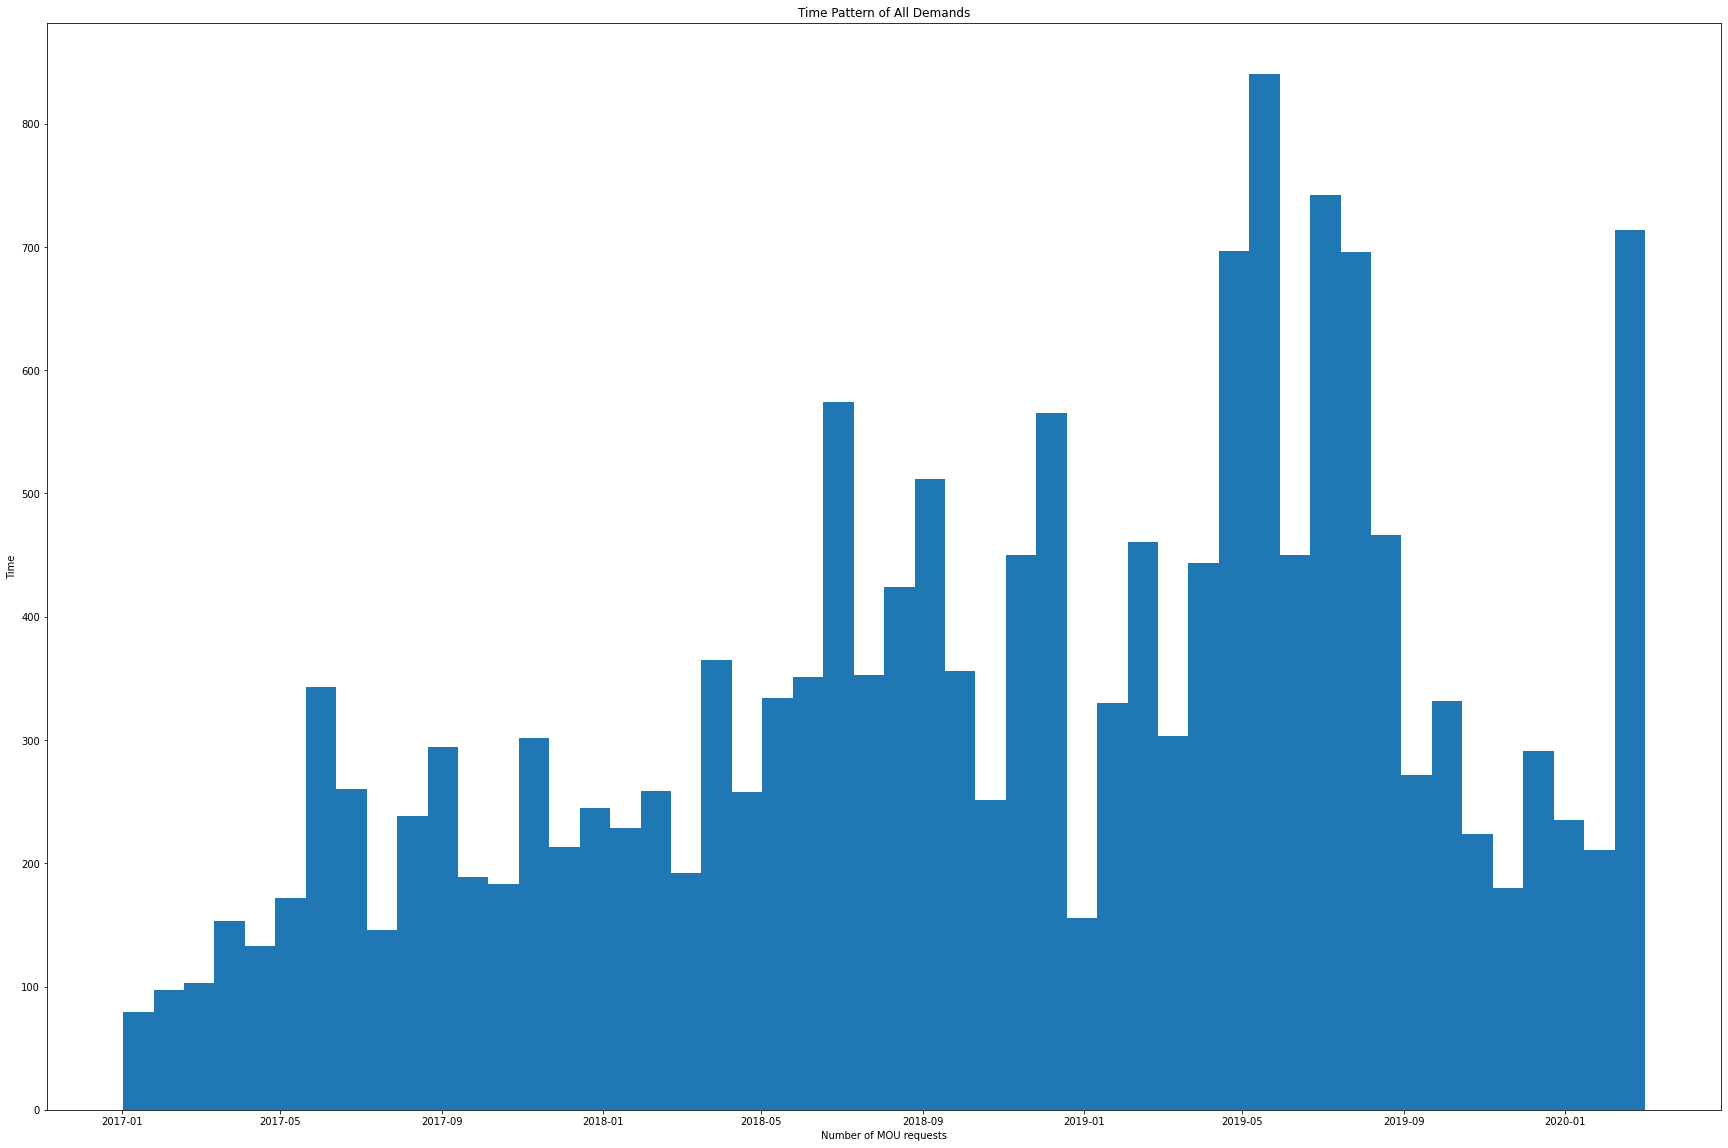

In [63]:
import datetime

def week_num_to_date(w):
    # return date of the first day of week
    return datetime.datetime.strptime(w + '-1', "%Y-%W-%w")

raw_demand_3yrs['fake_date'] = raw_demand_3yrs['year_week'].apply(week_num_to_date)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 30
fig_size[1] = 20
plt.rcParams["figure.figsize"] = fig_size

plt.hist(raw_demand_3yrs.fake_date, bins=50)
plt.title("Time Pattern of All Demands")
plt.ylabel("Time")
plt.xlabel("Number of MOU requests")
plt.show()

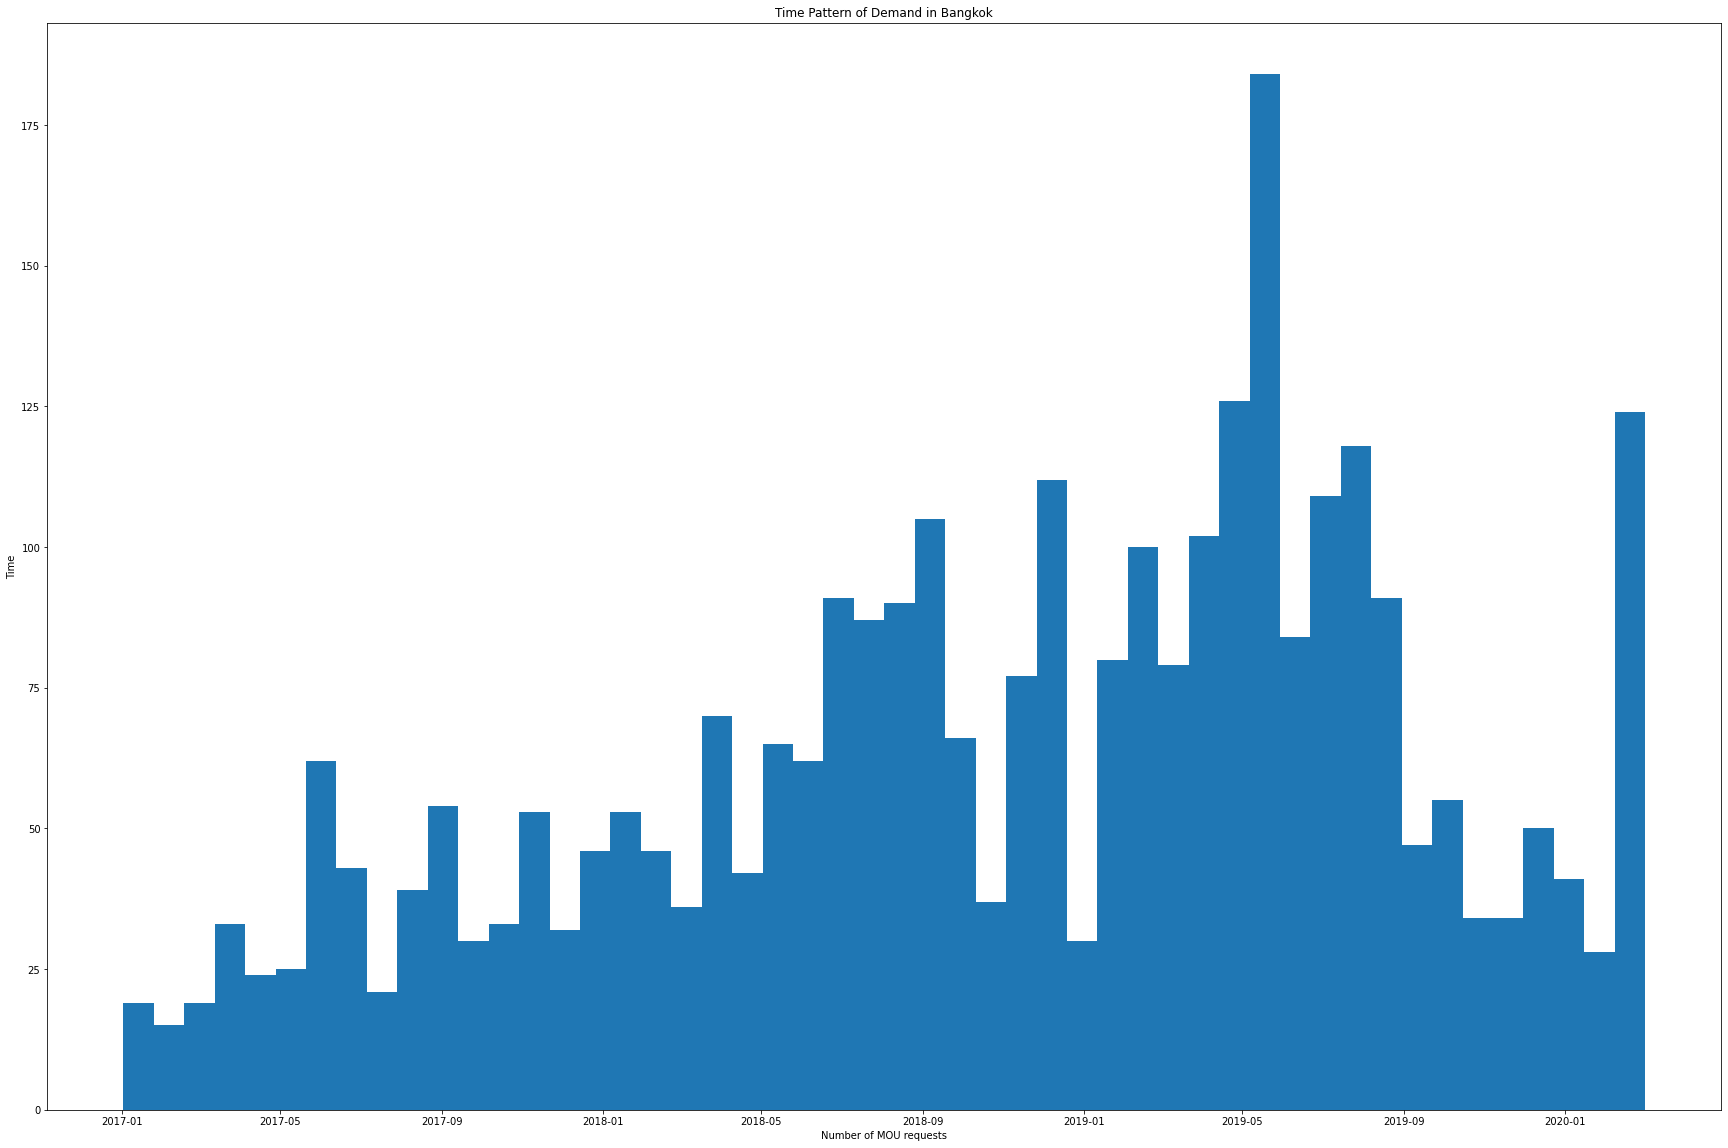

In [64]:
plt.hist(raw_demand_3yrs[raw_demand_3yrs.province=='Bangkok'].fake_date, bins=50)
plt.title("Time Pattern of Demand in Bangkok")
plt.ylabel("Time")
plt.xlabel("Number of MOU requests")
plt.show()